In [3]:
import zipfile
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
import random
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom, BatchNormalization,GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2
from scipy.optimize import minimize
from tensorflow.keras.regularizers import l2
import time

global_image_dim = 180

# Load Datasets

In [2]:
high_path = './high-quality'
low_path = './low-quality'
categories = ['real', 'fake']

data_high = []
data_low = []

for category in categories:
    high_folder_path = os.path.join(high_path, category)
    low_folder_path = os.path.join(low_path, category)
    label = 1 if category == 'real' else 0

    for file in os.listdir(high_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(high_folder_path, file)
            image = Image.open(file_path).convert('RGB')
            data_high.append((image, label))

    for file in os.listdir(low_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(low_folder_path, file)
            image = Image.open(file_path).convert('RGB')
            data_low.append((image, label))

## Show data examples : High quality 

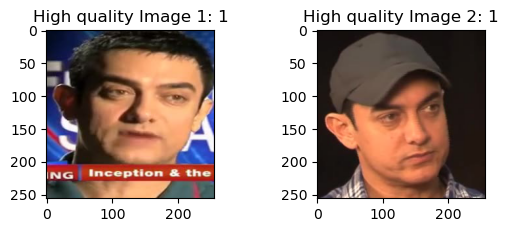

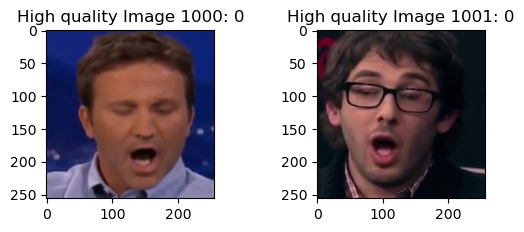

In [4]:
# Hight qulity 1 means real, 0 means fake
plt.subplot(2, 2, 1)  
plt.imshow(data_high[0][0], cmap='gray') 
plt.title(f'High quality Image 1: { data_high[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_high[1][0], cmap='gray')  
plt.title(f'High quality Image 2: { data_high[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_high[1000][0], cmap='gray') 
plt.title(f'High quality Image 1000: { data_high[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_high[1001][0], cmap='gray')  
plt.title(f'High quality Image 1001: { data_high[1001][1] }') 
plt.show() 

## Show data examples : Low quality 

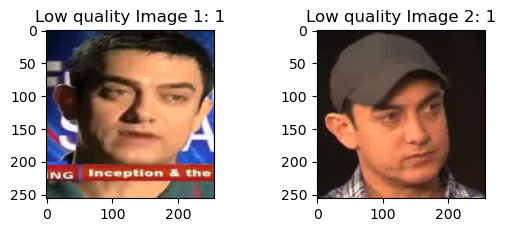

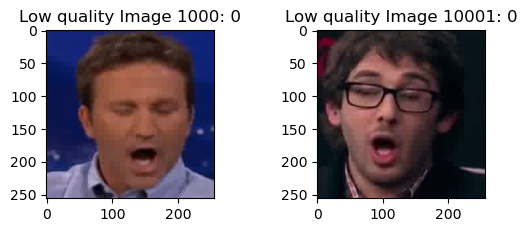

In [4]:
# Low qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_low[0][0], cmap='gray') 
plt.title(f'Low quality Image 1: { data_low[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_low[1][0], cmap='gray')  
plt.title(f'Low quality Image 2: { data_low[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[1000][0], cmap='gray') 
plt.title(f'Low quality Image 1000: { data_low[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[1001][0], cmap='gray')  
plt.title(f'Low quality Image 10001: { data_low[1001][1] }') 
plt.show() 

# preprocess data

In [5]:
#The order of elements in the list is disrupted
random.shuffle(data_high)
random.shuffle(data_low)

In [6]:
global_image_dim=180
def preprocess_data(data):
    processed_images = []
    labels = []
    for image, label in data:
        image = np.array(image.resize((global_image_dim, global_image_dim)))
        processed_images.append(image)
        labels.append(label)
    return np.array(processed_images), np.array(labels)

processed_high, labels_high = preprocess_data(data_high)
processed_low, labels_low = preprocess_data(data_low)

def display_images(images, cols=6, titles=None):
    num_images = min(len(images), 18)  
    rows = num_images // cols + (1 if num_images % cols else 0)
    plt.figure(figsize=(18, 4 * rows))
    for i in range(num_images):
        image = images[i]
        plt.subplot(rows, cols, i + 1)
        if len(image.shape) == 2:  # 灰度图像
            plt.imshow(image, cmap='gray')
        else:  
            plt.imshow(image)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Displaying processed images for low quality:


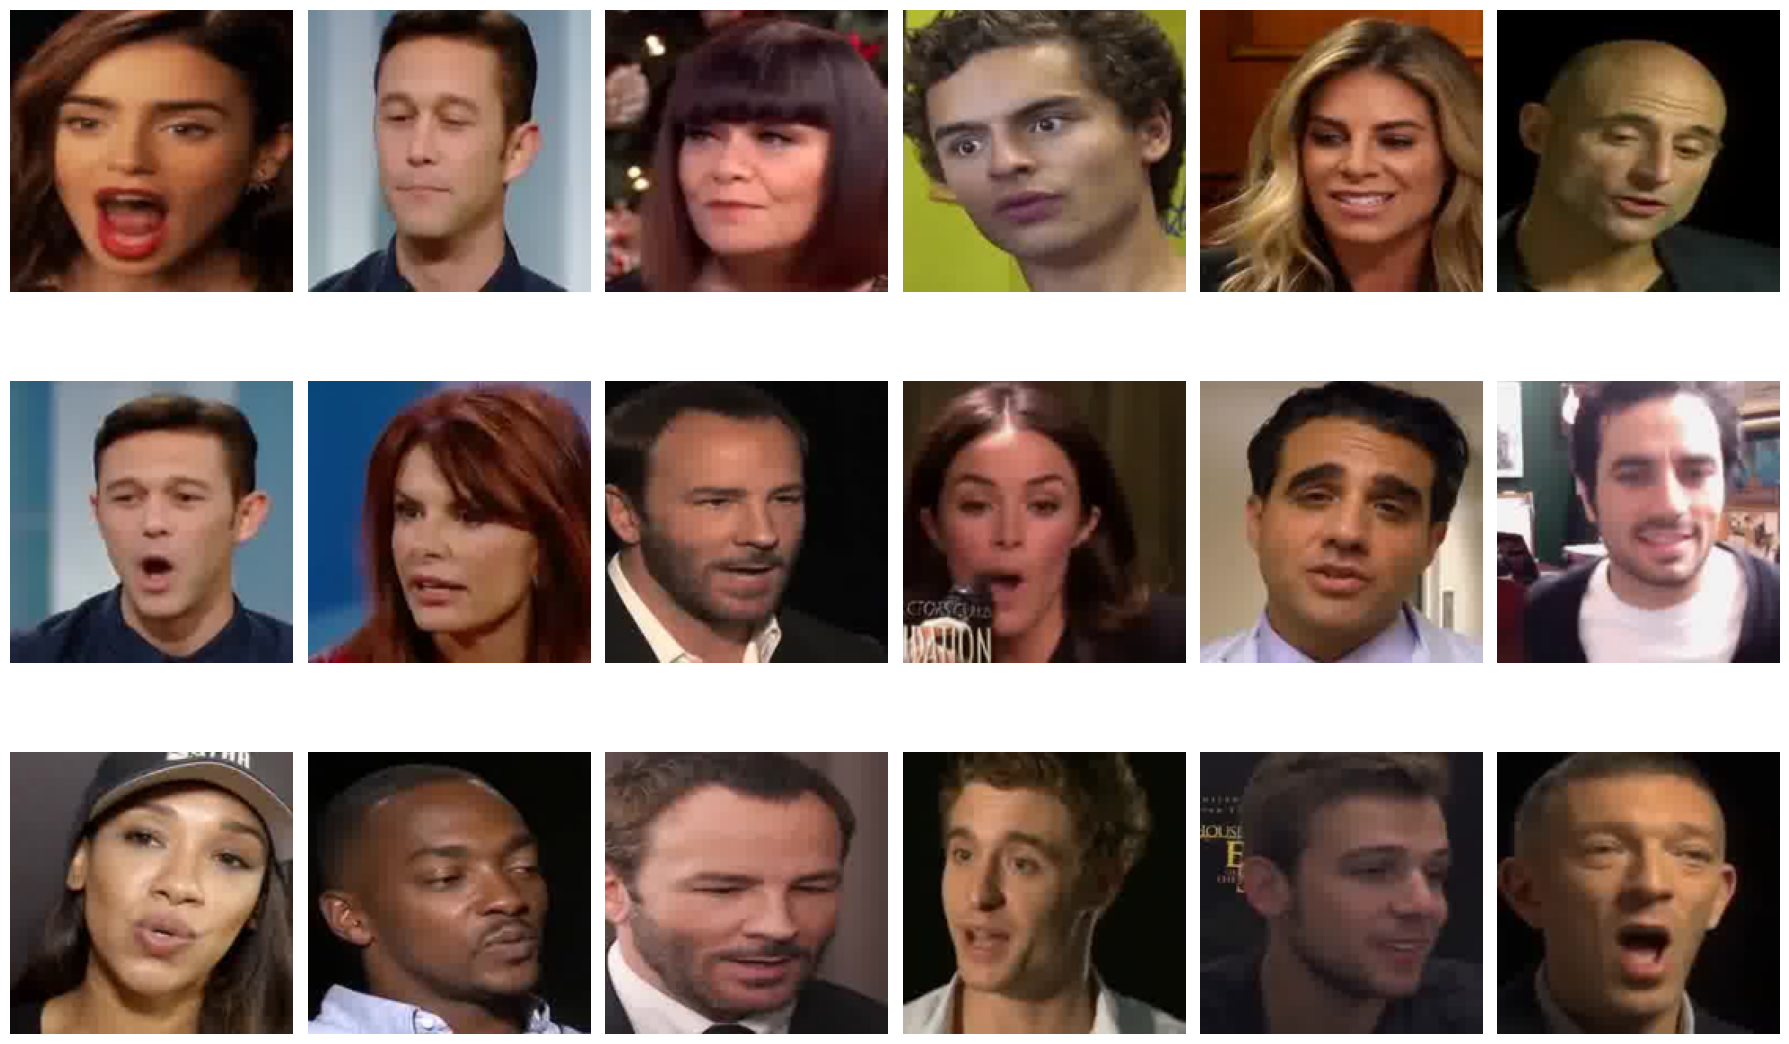

In [7]:
print("Displaying processed images for low quality:")
display_images(processed_low)

# Get CLAHE parameters : clip_limit, tile_grid_size

In [88]:
from scipy.optimize import differential_evolution


# Define image quality assessment functions (such as contrast)
def image_quality(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contrast = gray.std()  # Use standard deviation as contrast metric
    return contrast
# Optimization function for finding the best CLAHE parameters
def optimize_clahe_params_de(image):
    def objective(params):
        clip_limit, tile_grid_size = params
        try:
            img_clahe = apply_clahe(image, clip_limit, int(tile_grid_size))
            return -image_quality(img_clahe)  # Maximize contrast by minimizing the negative contrast
        except cv2.error:
            return np.inf  # Return a large value if there is an error
    bounds = [(1, 40), (1, 20)]  # Extended bounds for more comprehensive search
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=200, popsize=15, tol=0.001)
    return result.x

# k-fold

In [45]:
import numpy as np
from sklearn.model_selection import KFold

# Assuming `processed_low` is your list of images and `apply_clahe` and `image_quality` are defined functions.

start_time = time.time()
clip_limits = np.arange(1.0, 5.1, 1.0)
tile_grid_sizes = np.arange(1, 9, 1)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a dictionary to store best parameters for each image
best_params_per_image = {i: {'clip_limit': None, 'tile_grid_size': None, 'best_score': -np.inf} for i in range(len(processed_low))}

# Perform K-fold cross-validation
for train_index, val_index in kfold.split(processed_low):
    train_images = [processed_low[i] for i in train_index]
    val_images = [processed_low[i] for i in val_index]
    
    for img_idx, img in enumerate(train_images):
        # Parameter optimization
        for clip_limit in clip_limits:
            for tile_grid_size in tile_grid_sizes:
                img_clahe = apply_clahe(img, clip_limit, tile_grid_size)
                score = image_quality(img_clahe)
                
                if score > best_params_per_image[train_index[img_idx]]['best_score']:
                    best_params_per_image[train_index[img_idx]]['best_score'] = score
                    best_params_per_image[train_index[img_idx]]['clip_limit'] = clip_limit
                    best_params_per_image[train_index[img_idx]]['tile_grid_size'] = tile_grid_size

# Validate on validation set and update best parameters if necessary
for img_idx in range(len(processed_low)):
    best_params = best_params_per_image[img_idx]
    if best_params['clip_limit'] is not None and best_params['tile_grid_size'] is not None:
        img = processed_low[img_idx]
        img_clahe = apply_clahe(img, best_params['clip_limit'], best_params['tile_grid_size'])
        score = image_quality(img_clahe)
        if score > best_params['best_score']:
            best_params['best_score'] = score
            best_params['clip_limit'] = best_params['clip_limit']
            best_params['tile_grid_size'] = best_params['tile_grid_size']

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")


Time taken: 480.735955953598 seconds


Displaying CLAHE enhanced images of high quality:


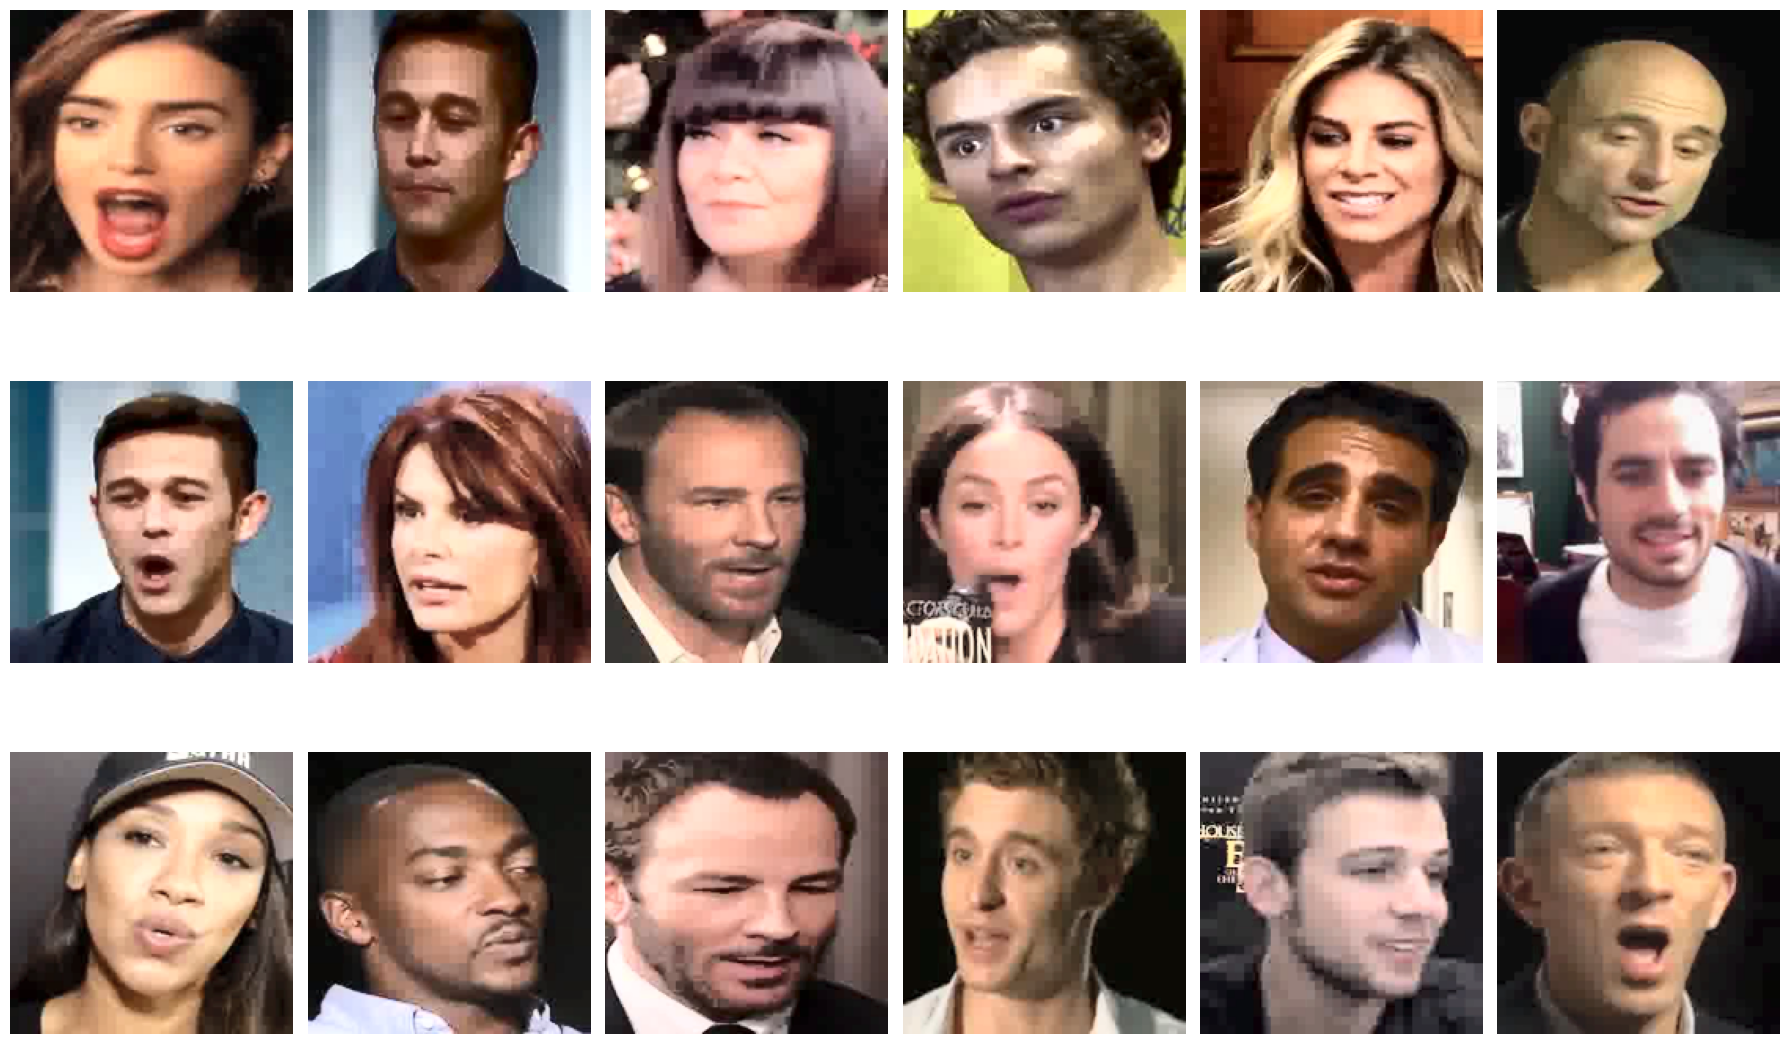

Time taken for applying CLAHE: 2.8196558952331543 seconds


In [51]:
start_time = time.time()
optimal_clahe_params = [(best_params_per_image[i]['clip_limit'], best_params_per_image[i]['tile_grid_size']) for i in range(len(processed_low))]
enhanced_images_low_k = []
for i in range(len(processed_low)):
    img = processed_low[i]
    clip_limit, tile_grid_size = optimal_clahe_params[i]
    enhanced_image = apply_clahe(img, clip_limit, int(tile_grid_size))
    enhanced_images_low_k.append(enhanced_image)
end_time = time.time()

print("Displaying CLAHE enhanced images of high quality:")
display_images(enhanced_images_low_k)
print(f"Time taken for applying CLAHE: {end_time - start_time} seconds")

# Apply CLAHE

In [86]:
def apply_clahe(image, clip_limit, tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels

    tile_grid_size_int = int(tile_grid_size)
    l = l.astype(np.uint8)  # Ensure that the L channel is an 8-bit unsigned integer type

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))
    l_clahe = clahe.apply(l)  # Apply to L channel

    # Ensure that the channels are of the same size before merging
    assert l_clahe.shape == a.shape == b.shape, "Channel shapes are not equal!"

    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return np.array(Image.fromarray(img_clahe_rgb))

In [89]:
start_time = time.time()
optimal_clahe_params_d = [optimize_clahe_params_de(img) for img in processed_low]
enhanced_images_low = []
for i in range(len(processed_low)):
    img = processed_low[i]
    clip_limit, tile_grid_size = optimal_clahe_params_d[i]
    enhanced_image = apply_clahe(img, clip_limit, int(tile_grid_size))
    enhanced_images_low.append(enhanced_image)
# End timer
end_time = time.time()

Displaying CLAHE enhanced images:


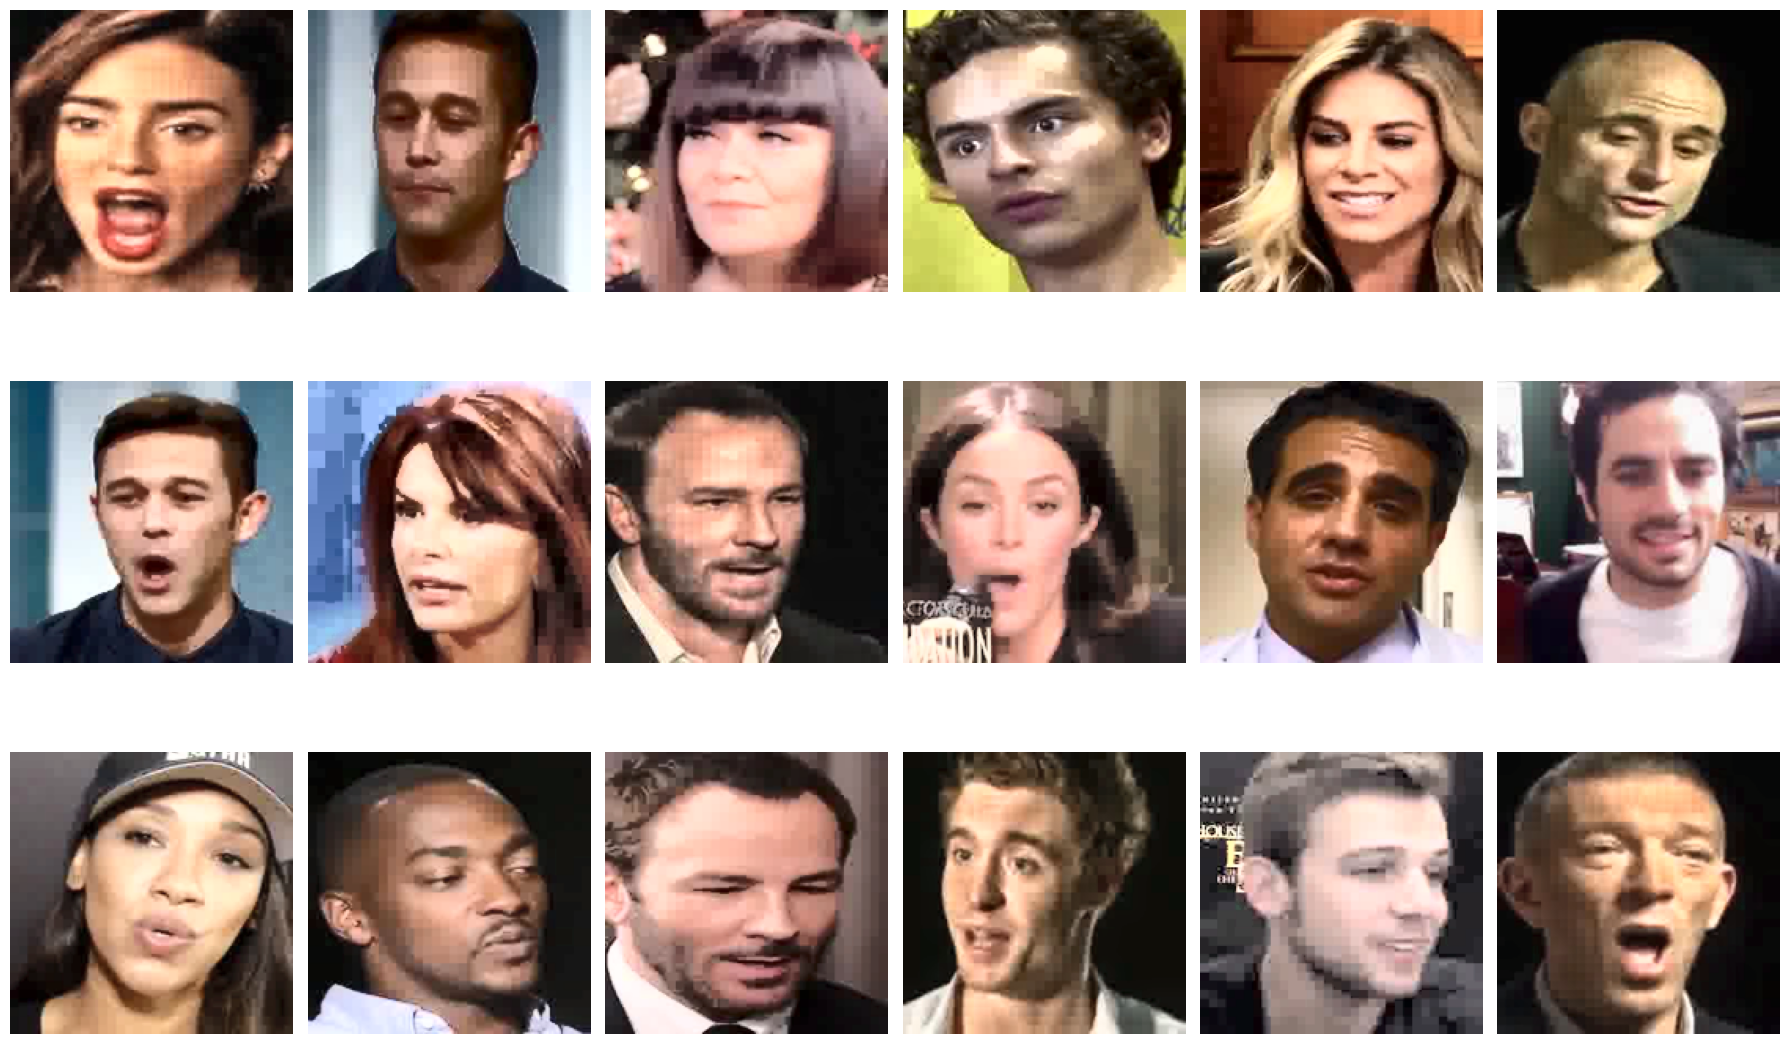

Time taken: 1277.0650498867035 seconds


In [90]:
# Display the CLAHE enhanced image
print("Displaying CLAHE enhanced images:")
display_images(enhanced_images_low)
print(f"Time taken: {end_time - start_time} seconds")

# Build Model

In [9]:
def build_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def get_model(num_classes = 2):
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    # return model
    
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(global_image_dim,
                                      global_image_dim,
                                      3)),
    RandomRotation(0.1),
    #RandomZoom(0.1),
      ]
    )

    model = Sequential([
          data_augmentation,
          # layers.Rescaling(1./255),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(128, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation='relu'),
          layers.Dense(num_classes, name="outputs")
        ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model
model = get_model()



C:\Users\28612\anaconda3\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train Model on low quality enhanced images

In [91]:
X_train_low_c, X_test_low_c, y_train_low_c, y_test_low_c = train_test_split(enhanced_images_low, labels_low, test_size=0.2) #low quality di

X_train_low_a, X_test_low_a, y_train_low_a, y_test_low_a = train_test_split(enhanced_images_low_k, labels_low, test_size=0.2) #low quality k

X_train_low_raw, X_test_low_raw, y_train_low_raw, y_test_low_raw = train_test_split(processed_low, labels_low, test_size=0.2) #raw low quality

In [92]:
X_train_low_c = np.array(X_train_low_c)
y_train_low_c = np.array(y_train_low_c)
X_test_low_c = np.array(X_test_low_c)
y_test_low_c = np.array(y_test_low_c)


X_train_low_a = np.array(X_train_low_a)
y_train_low_a = np.array(y_train_low_a)
X_test_low_a = np.array(X_test_low_a)
y_test_low_a = np.array(y_test_low_a)


X_train_low_raw = np.array(X_train_low_raw)
y_train_low_raw = np.array(y_train_low_raw)
X_test_low_raw = np.array(X_test_low_raw)
y_test_low_raw = np.array(y_test_low_raw)


print(f"X_train_low_c shape: {X_train_low_c.shape}, y_train_low_c shape: {y_train_low_c.shape}")
print(f"X_test_low_c shape: {X_test_low_c.shape}, y_test_low_c shape: {y_test_low_c.shape}\n")


print(f"X_train_low_a shape: {X_train_low_a.shape}, y_train_low_a shape: {y_train_low_a.shape}")
print(f"X_test_low_a shape: {X_test_low_a.shape}, y_test_low_a shape: {y_test_low_a.shape}\n")

print(f"X_train_low_raw shape: {X_train_low_raw.shape}, y_train_low_raw shape: {y_train_low_raw.shape}")
print(f"X_test_low_raw shape: {X_test_low_raw.shape}, y_test_low_raw shape: {y_test_low_raw.shape}")


X_train_low_c shape: (1381, 180, 180, 3), y_train_low_c shape: (1381,)
X_test_low_c shape: (346, 180, 180, 3), y_test_low_c shape: (346,)

X_train_low_a shape: (1381, 180, 180, 3), y_train_low_a shape: (1381,)
X_test_low_a shape: (346, 180, 180, 3), y_test_low_a shape: (346,)

X_train_low_raw shape: (1381, 180, 180, 3), y_train_low_raw shape: (1381,)
X_test_low_raw shape: (346, 180, 180, 3), y_test_low_raw shape: (346,)


In [93]:
history = model.fit(X_train_low_c, y_train_low_c, batch_size=64, epochs=30, validation_data=(X_test_low_c, y_test_low_c))
loss, accuracy = model.evaluate(X_test_low_c, y_test_low_c)
print(accuracy)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.8069 - loss: 0.7294 - val_accuracy: 0.8873 - val_loss: 0.6160
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8382 - loss: 0.6865 - val_accuracy: 0.8728 - val_loss: 0.6410
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.8383 - loss: 0.6601 - val_accuracy: 0.8786 - val_loss: 0.6232
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.8383 - loss: 0.6641 - val_accuracy: 0.8844 - val_loss: 0.6230
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.8627 - loss: 0.6228 - val_accuracy: 0.8844 - val_loss: 0.6229
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.8424 - loss: 0.6471 - val_accuracy: 0.8613 - val_loss: 0.6381
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.8556 - loss: 0.6377 - val_accuracy: 0.8526 - val_loss: 0.6410
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.8695 - loss: 0.6107 - val_accuracy: 0.

In [78]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=64, epochs=10):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return loss, accuracy
model = build_model(input_shape=(global_image_dim,global_image_dim, 3))

C:\Users\28612\AppData\Local\Temp\ipykernel_21532\2125306153.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9485 - loss: 0.4317 - val_accuracy: 0.8526 - val_loss: 0.6588
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.9396 - loss: 0.4424 - val_accuracy: 0.8613 - val_loss: 0.6478
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.9382 - loss: 0.4345 - val_accuracy: 0.8468 - val_loss: 0.6677
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.9535 - loss: 0.4197 - val_accuracy: 0.8555 - val_loss: 0.6542
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9514 - loss: 0.4196 - val_accuracy: 0.8497 - val_loss: 0.6675
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.9501 - loss: 0.4202 - val_accuracy: 0.8526 - val_loss: 0.6568
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.9618 - loss: 0.4021 - val_accuracy: 0.8526 - val_loss: 0.6697
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.9463 - loss: 0.4123 - val_accuracy: 0.

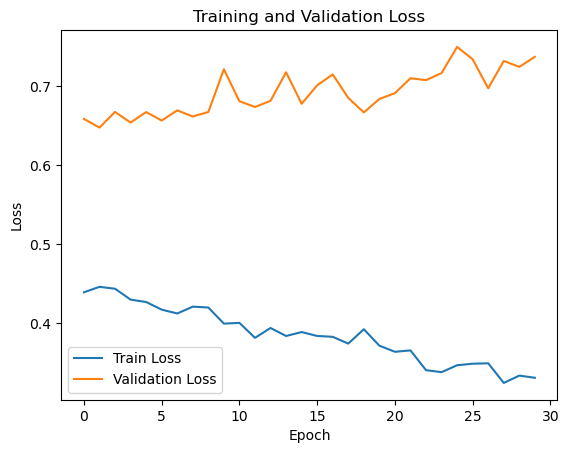

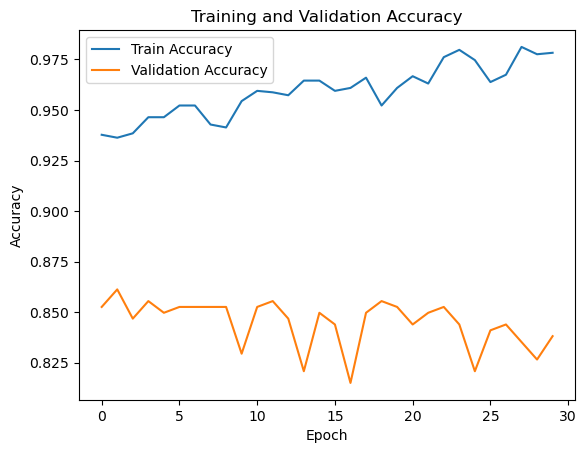

In [95]:
start_time = time.time()
loss, accuracy = train_and_evaluate_model(model, X_train_low_c, y_train_low_c, X_test_low_c, y_test_low_c, epochs=30)
end_time = time.time()
duration = end_time - start_time

In [59]:
print(duration)

224.59981060028076


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.7232 - loss: 0.9542 - val_accuracy: 0.7486 - val_loss: 0.9225
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.6960 - loss: 0.9855 - val_accuracy: 0.7341 - val_loss: 0.9194
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.7149 - loss: 0.9493 - val_accuracy: 0.7486 - val_loss: 0.9171
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.7302 - loss: 0.9342 - val_accuracy: 0.7457 - val_loss: 0.9114
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.7471 - loss: 0.9170 - val_accuracy: 0.7399 - val_loss: 0.9069
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.7099 - loss: 0.9248 - val_accuracy: 0.7254 - val_loss: 0.9088
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.7540 - loss: 0.8951 - val_accuracy: 0.7486 - val_loss: 0.9075
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.7460 - loss: 0.8964 - val_accuracy: 0.

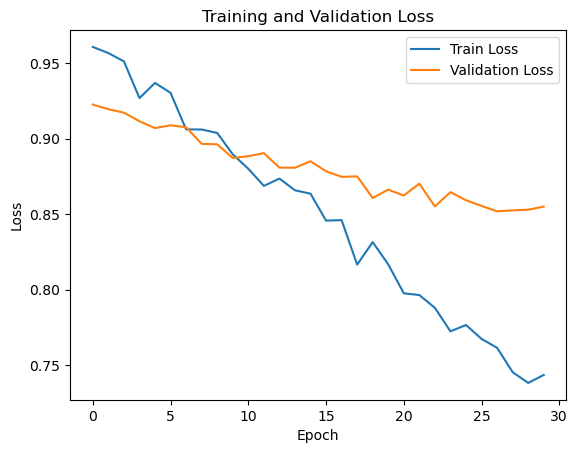

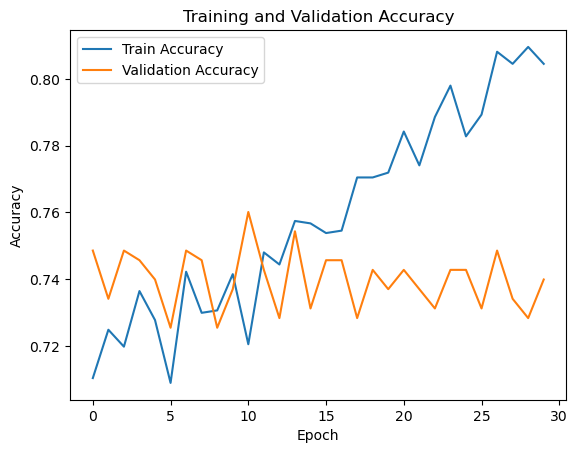

In [60]:
start_time = time.time()
accuracy2, loss2=train_and_evaluate_model(model, X_train_low_a, y_train_low_a, X_test_low_a, y_test_low_a, epochs=30)
end_time = time.time()
duration = end_time - start_time

In [61]:
print(duration)

219.91561150550842


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.5788 - loss: 0.9388 - val_accuracy: 0.7139 - val_loss: 0.8624
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.6586 - loss: 0.8830 - val_accuracy: 0.7197 - val_loss: 0.8519
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.6510 - loss: 0.8905 - val_accuracy: 0.7081 - val_loss: 0.8503
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.6983 - loss: 0.8438 - val_accuracy: 0.7168 - val_loss: 0.8282
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.7131 - loss: 0.8200 - val_accuracy: 0.7399 - val_loss: 0.8157
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.7127 - loss: 0.8156 - val_accuracy: 0.7197 - val_loss: 0.8189
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.7273 - loss: 0.7923 - val_accuracy: 0.7341 - val_loss: 0.8147
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.7394 - loss: 0.7984 - val_accuracy: 0.

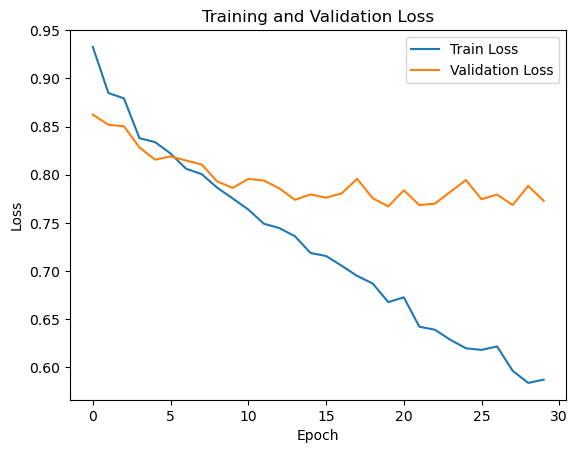

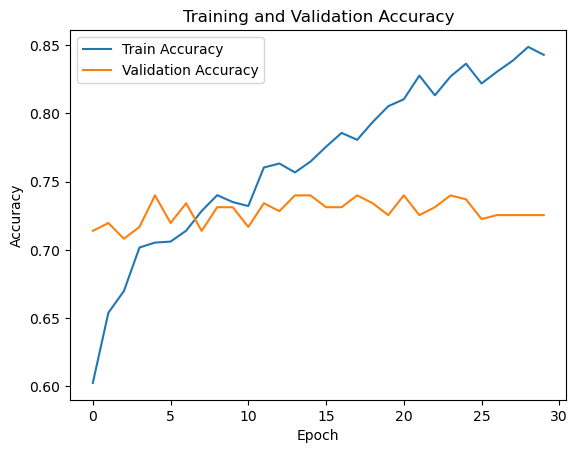

214.6639165878296


In [37]:
start_time = time.time()
accuracy3, loss3=train_and_evaluate_model(model, X_train_low_raw, y_train_low_raw, X_test_low_raw, y_test_low_raw, epochs=30)
end_time = time.time()
duration = end_time - start_time
print(duration)

In [94]:
import pandas as pd
data = {
    'Model': ['Differential_evolution', 'K-fold_cross validation', 'No CLAHE'],
    'Accuracy': [accuracy, accuracy2, accuracy3],  
    'Loss': [loss, loss2,loss3]       
}

df = pd.DataFrame(data)
df

Model  Accuracy      Loss
0   Differential_evolution  0.867052  0.644202
1  K-fold_cross validation  0.854991  0.739884
2                 No CLAHE  0.725434  0.772816